In [1]:
# 의사결정나무 

In [27]:
import numpy as np
import seaborn as sns

from pandas import read_csv, DataFrame
from matplotlib import pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_predict

In [3]:
train = read_csv('./res/train.csv')
test = read_csv('./res/test.csv')
print(train.shape,test.shape)
train.head()


(891, 12) (418, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
origin_train = train.copy()
origin_test = test.copy()

In [7]:
# 훈련데이터와 검증데이터를 병합하여 전체 데이터셋 구성
full_data = [train,test]
full_data

[     PassengerId  Survived  Pclass  \
 0              1         0       3   
 1              2         1       1   
 2              3         1       3   
 3              4         1       1   
 4              5         0       3   
 ..           ...       ...     ...   
 886          887         0       2   
 887          888         1       1   
 888          889         0       3   
 889          890         1       1   
 890          891         0       3   
 
                                                   Name     Sex   Age  SibSp  \
 0                              Braund, Mr. Owen Harris    male  22.0      1   
 1    Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
 2                               Heikkinen, Miss. Laina  female  26.0      0   
 3         Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
 4                             Allen, Mr. William Henry    male  35.0      0   
 ..                                               

### 데이터 전처리

In [8]:
# 객실 유무 
train['Has_Cabin'] = train['Cabin'].apply(lambda x : 0 if type(x) == float else 1)
test['Has_Cabin'] = test['Cabin'].apply(lambda x : 0 if type(x) == float else 1)

# 가족 구성원 수 
train['FamilySize'] = train['SibSp'].apply(lambda x : 0 if type(x) == float else 1)
test['FamilySize'] = test['SibSp'].apply(lambda x : 0 if type(x) == float else 1)

# 혼자 탑승했는지 여부
train['ISAlone'] = 0
train.loc[train['FamilySize'] == 1, 'ISAlone'] = 1

test['ISAlone'] = 0
test.loc[train['FamilySize'] == 1, 'ISAlone'] = 1


In [9]:
# 탑승지 결측치 처리
train['Embarked'] = train['Embarked'].fillna('S')
test['Embarked'] = test['Embarked'].fillna('S')

# 요금데이터의 결측치 처리
train['Fare'] = train['Fare'].fillna(train['Fare'].median())
test['Fare'] = test['Fare'].fillna(test['Fare'].median())

### 훈련데이터

In [10]:
# 결측치 데이터의 인덱스 찾기 
age_avg = train['Age'].mean()
age_std = train['Age'].std()
age_null_count = train['Age'].isnull().sum()
age_null_ran_List = np.random.randint(age_avg - age_std, age_avg + age_std, size = age_null_count)
# 결측치에 해당하는 행에 랜덤값을 채워준다. 
train.loc[np.isnan(train['Age']),'Age'] = age_null_ran_List
train['Age'] = train['Age'].astype(int)

In [11]:
# 검증데이터
age_avg = test['Age'].mean()
age_std = test['Age'].std()
age_null_count = test['Age'].isnull().sum()
age_null_ran_List = np.random.randint(age_avg - age_std, age_avg + age_std, size = age_null_count)
# 결측치에 해당하는 행에 랜덤값을 채워준다. 
test.loc[np.isnan(test['Age']),'Age'] = age_null_ran_List
test['Age'] = test['Age'].astype(int)

In [12]:
import re

# 정규표현식 처리 함수 
# 이름에서 알파벳을 제외한 나머지 글자를 제외하고 어절단위로 리스트를 묶은 후 인덱스가 1인 위치를 리턴하는 함수

def get_title(name) :
    title_search=re.search(' ([A-Za-z]+)\.',name)
    if title_search:
        return title_search.group(1)
    
    return ""


In [13]:
train['Title'] = train["Name"].apply(get_title)
print(list(train['Title'].value_counts().index))


['Mr', 'Miss', 'Mrs', 'Master', 'Dr', 'Rev', 'Mlle', 'Major', 'Col', 'Countess', 'Capt', 'Ms', 'Sir', 'Lady', 'Mme', 'Don', 'Jonkheer']


In [14]:
if 'Title' in test.columns:
    print('Y')
else:
    print("The 'Title' column does not exist in the 'test' DataFrame.")


The 'Title' column does not exist in the 'test' DataFrame.


In [15]:
test['Title'] = test["Name"].apply(get_title)

In [16]:
train['Title'] = train['Title'].replace(['Dr', 'Rev', 'Mlle', 'Major', 'Col', 'Countess', 'Capt', 'Ms', 'Sir', 'Lady', 'Mme', 'Don', 'Jonkheer'], 'Rare')
test['Title'] = test['Title'].replace(['Dr', 'Rev', 'Mlle', 'Major', 'Col', 'Countess', 'Capt', 'Ms', 'Sir', 'Lady', 'Mme', 'Don', 'Jonkheer'], 'Rare')

### 데이터 라벨링

In [17]:
# 성별
train['Sex'] = train['Sex'].map({'female':0,'male':1})
test['Sex'] = test['Sex'].map({'female':0,'male':1})

# 호칭
train['Title'] = train['Title'].map({"Mr":1,"Master":2,"Mrs":3,"Miss":4,"Rare":5})
test['Title'] = test['Title'].map({"Mr":1,"Master":2,"Mrs":3,"Miss":4,"Rare":5})

# 탑승지
train['Embarked'] = train['Embarked'].map({'S':0,"C":1,'Q':2})
test['Embarked'] = test['Embarked'].map({'S':0,"C":1,'Q':2})

# 연령대 분할

train.loc[train["Age"] <= 16, 'Age'] = 0
train.loc[(train['Age'] > 16) & (train['Age'] <= 32), "Age"] =1 
train.loc[(train['Age'] > 32) & (train['Age'] <= 48), "Age"] =2 
train.loc[(train['Age'] > 48) & (train['Age'] <= 64), "Age"] =3
train.loc[train["Age"] > 64, 'Age'] = 4

test.loc[test["Age"] <= 16, 'Age'] = 0
test.loc[(test['Age'] > 16) & (test['Age'] <= 32), "Age"] =1 
test.loc[(test['Age'] > 32) & (test['Age'] <= 48), "Age"] =2 
test.loc[(test['Age'] > 48) & (test['Age'] <= 64), "Age"] =3
test.loc[test["Age"] > 64, 'Age'] = 4

In [18]:
# 탑승요금 분할
# 탑승요금의 최대/최소, 사분위수 확인 
train['Fare'].quantile([0,0.25,0.5,0.75,1.0])

train.loc[train["Fare"] <= 7.91, 'Fare'] = 0
train.loc[(train['Fare'] > 7.91) & (train['Fare'] <= 14.454), "Fare"] =1 
train.loc[(train['Fare'] > 14.454) & (train['Fare'] <= 31), "Fare"] =2 
train.loc[train["Fare"] > 31, 'Fare'] = 3

test.loc[test["Fare"] <= 7.91, 'Fare'] = 0
test.loc[(test['Fare'] > 7.91) & (test['Fare'] <= 14.454), "Fare"] =1 
test.loc[(test['Fare'] > 14.454) & (test['Fare'] <= 31), "Fare"] =2 
test.loc[test["Fare"] > 31, 'Fare'] = 3

In [19]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Has_Cabin,FamilySize,ISAlone,Title
0,1,0,3,"Braund, Mr. Owen Harris",1,1,1,0,A/5 21171,0.0,NaN,0,0,1,1,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,0,PC 17599,3.0,C85,1,1,1,1,3
2,3,1,3,"Heikkinen, Miss. Laina",0,1,0,0,STON/O2. 3101282,1.0,NaN,0,0,1,1,4
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,2,1,0,113803,3.0,C123,0,1,1,1,3
4,5,0,3,"Allen, Mr. William Henry",1,2,0,0,373450,1.0,NaN,0,0,1,1,1


In [20]:
print(train.columns)


Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Has_Cabin',
       'FamilySize', 'ISAlone', 'Title'],
      dtype='object')


In [21]:
# 불필요한 필드 제거
drop_elements = ["PassengerId",'Name','Ticket','Cabin','SibSp']
train = train.drop(drop_elements, axis=1)
test = test.drop(drop_elements, axis=1)
train.head()

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Has_Cabin,FamilySize,ISAlone,Title
0,0,3,1,1,0,0.0,0,0,1,1,1
1,1,1,0,2,0,3.0,1,1,1,1,3
2,1,3,0,1,0,1.0,0,0,1,1,4
3,1,1,0,2,0,3.0,0,1,1,1,3
4,0,3,1,2,0,1.0,0,0,1,1,1


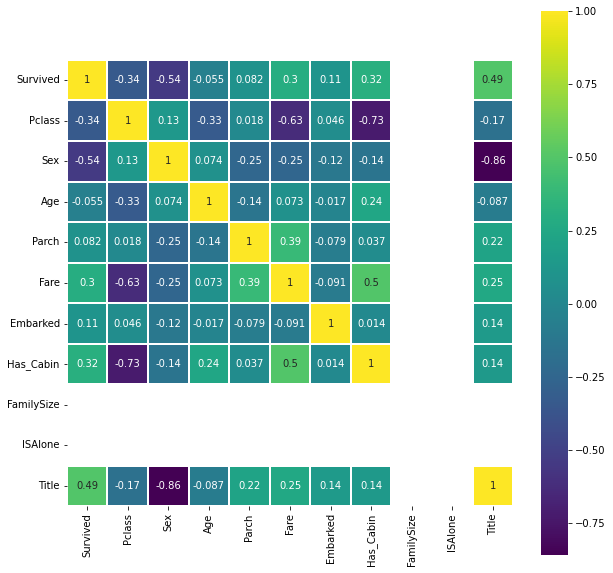

In [22]:
plt.figure(figsize=(10,10))
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0,square=True,cmap=plt.cm.viridis,
            linecolor='white',annot=True)
plt.show()
plt.close()

In [23]:
# 선정된 최종 변수

x_train = train.drop(['Sex', 'Age', 'Survived'], axis=1)
y_train = train['Survived']


# 의사결정트리 구현

#### 최적의 파라미터 찾기


In [28]:
from sklearn.model_selection import GridSearchCV
# DecisionTreeClassifier 초기화
dtree = DecisionTreeClassifier(random_state=777)

# 하이퍼파라미터 그리드 정의
params = {
    'max_depth': [3, 5, 7, 9],
    'min_samples_split': [2, 3, 4],
    'splitter': ['best', 'random']
}

# 그리드 서치 객체 초기화
grid_dt = GridSearchCV(dtree, param_grid=params, cv=5, n_jobs=-1)

# 그리드 서치 수행
grid_dt.fit(x_train, y_train)

# 최적 하이퍼파라미터와 최상의 점수 출력
print(grid_dt.best_params_, grid_dt.best_score_)

# 결과 DataFrame 생성
result = DataFrame(grid_dt.cv_results_['params'])

# 평균 테스트 스코어 열 추가
result['mean_test_score'] = grid_dt.cv_results_['mean_test_score']

# 평균 테스트 스코어를 기준으로 내림차순 정렬
result.sort_values(by='mean_test_score', ascending=False)


{'max_depth': 9, 'min_samples_split': 3, 'splitter': 'random'} 0.8114619295712762


,max_depth,min_samples_split,splitter,mean_test_score
21,9,3,random,0.811462
23,9,4,random,0.810332
17,7,4,random,0.806961
4,3,4,best,0.806930
0,3,2,best,0.806930
2,3,3,best,0.806930
6,5,2,best,0.805831
8,5,3,best,0.805831
10,5,4,best,0.805831
13,7,2,random,0.803609


In [29]:
# 검증데이터를 훈련데이터와 동일하게 필터링
test_df = test.filter(x_train.columns)
test_df

,Pclass,Parch,Fare,Embarked,Has_Cabin,FamilySize,ISAlone,Title
0,3,0,0.0,2,0,1,1,1.0
1,3,0,0.0,0,0,1,1,3.0
2,2,0,1.0,2,0,1,1,1.0
3,3,0,1.0,0,0,1,1,1.0
4,3,1,1.0,0,0,1,1,3.0
...,...,...,...,...,...,...,...,...
413,3,0,1.0,0,0,1,1,1.0
414,1,0,3.0,1,1,1,1,NaN
415,3,0,0.0,0,0,1,1,1.0
416,3,0,1.0,0,0,1,1,1.0


### 최종모델


In [33]:
# dtree = DecisionTreeClassifier(random_state=777,
#                                max_depth=grid_dt.best_params_['max_depth'],
#                                min_samples_split=grid_dt.best_params_['min_samples_split'],
#                                splitter=grid_dt.best_params_['splitter'])

# dtree.fit(x_train,y_train)
# y_pred = dtree.predict(test_df)
# print(dtree.score(x_train,y_train))
# y_pred[:5]

dtree = DecisionTreeClassifier(random_state=777, **grid_dt.best_params_).fit(x_train, y_train)
y_pred = dtree.predict(test_df)


ValueError: Input X contains NaN.
DecisionTreeClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

### 결과 시각화 

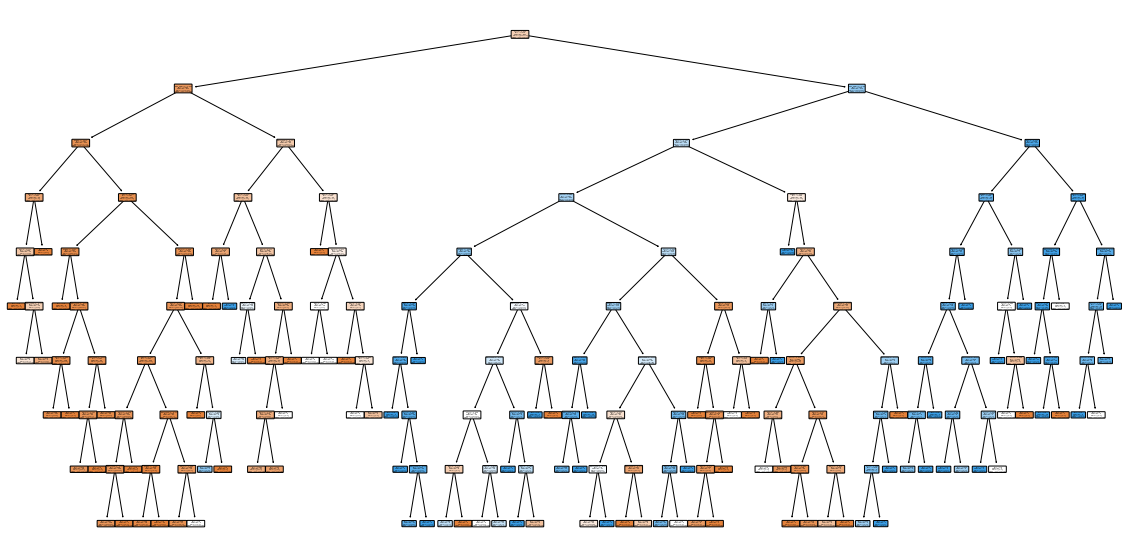

In [34]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
_ = plot_tree(dtree, feature_names=list(x_train.columns), class_names=['Not Survived', 'Survived'], rounded=True, filled=True)
plt.show()
plt.close()


In [36]:
! pip install dtreeviz

  Obtaining dependency information for dtreeviz from https://files.pythonhosted.org/packages/b3/e8/44eb59345d8ba9d2f6610df6441d63082f46021c1685de24716c22f55383/dtreeviz-2.2.2-py3-none-any.whl.metadata
     ---------------------------------------- 47.0/47.0 kB 1.2 MB/s eta 0:00:00
  Obtaining dependency information for pytest from https://files.pythonhosted.org/packages/df/d0/e192c4275aecabf74faa1aacd75ef700091913236ec78b1a98f62a2412ee/pytest-7.4.2-py3-none-any.whl.metadata
  Obtaining dependency information for pluggy<2.0,>=0.12 from https://files.pythonhosted.org/packages/05/b8/42ed91898d4784546c5f06c60506400548db3f7a4b3fb441cba4e5c17952/pluggy-1.3.0-py3-none-any.whl.metadata
   ---------------------------------------- 91.8/91.8 kB 2.6 MB/s eta 0:00:00
   ---------------------------------------- 324.5/324.5 kB 6.7 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [37]:
import dtreeviz

viz = dtreeviz.dtreeviz(dtree, X_train=x_train, y_train=y_train, target_name="titanic", feature_names=x_train.columns, class_names=['Not Survived', 'Survived'])
viz.view(scale=2.0)


C:\Users\hare0\AppData\Local\Temp\ipykernel_66052\1207967126.py:3: DeprecationWarning: dtreeviz() function is deprecated starting from version 2.0. 
 For the same functionality, please use this code instead: 
 m = dtreeviz.model(...) 
 m.view()


TypeError: 'int' object is not subscriptable